In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=ea48066873c047caaa387e09c4d8eb7ff5701568fafac087b3358bd6eb635186
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# 1. Load and clean data
raw = pd.read_csv("./compas-scores-two-years.csv")
# Select relevant columns and apply filters
df = raw.loc[
    (raw.days_b_screening_arrest <= 30) &
    (raw.days_b_screening_arrest >= -30) &
    (raw.is_recid != -1) &
    (raw.c_charge_degree != 'O') &
    (raw.score_text != 'N/A'),
    ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
     'priors_count', 'days_b_screening_arrest', 'decile_score',
     'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
].copy()

# 2. Basic counts and percentages
total = len(df)
recid_count = df.two_year_recid.sum()
print(f"Total records: {total}")
print(f"Recidivism count: {recid_count}")

df['length_of_stay'] = pd.to_numeric(pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in']))
# Convert timedelta to days
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days
# The .dt.days accessor is used directly on the timedelta result
correlation = df['length_of_stay'].corr(df['decile_score'])
print(f"Correlation between length of stay and decile score: {correlation}")

df["age_cat"].value_counts()

Total records: 6172
Recidivism count: 2809
Correlation between length of stay and decile score: 0.20747808478031807


,count
age_cat,
25 - 45,3532
Less than 25,1347
Greater than 45,1293


In [ ]:
df["race"].value_counts()

,count
race,
African-American,3175
Caucasian,2103
Hispanic,509
Other,343
Asian,31
Native American,11


Recidivism rate: 45.51%
Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


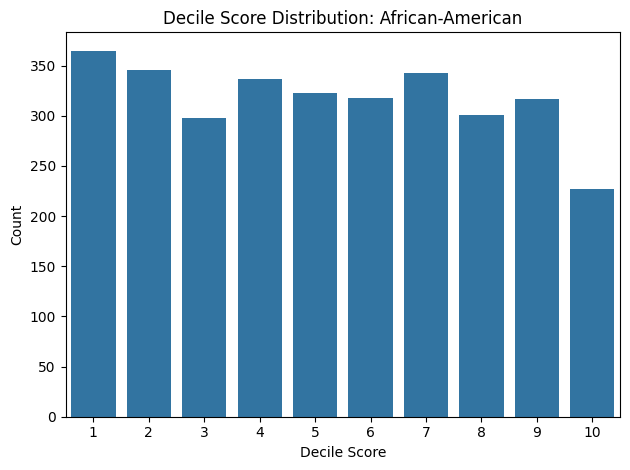

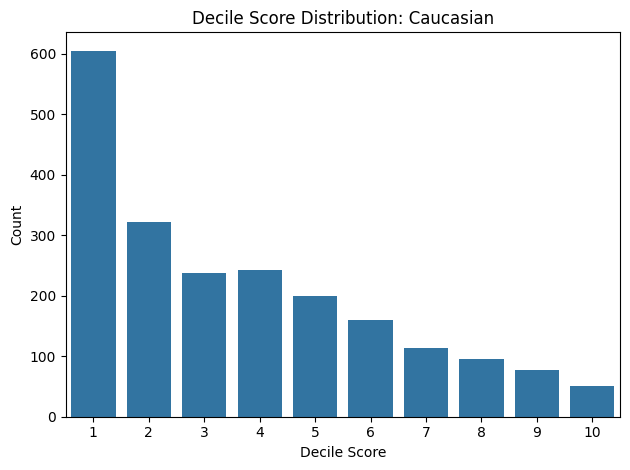

In [ ]:
print(f"Recidivism rate: {recid_count/total*100:.2f}%")

print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

# 3. Distribution by decile_score for African-American vs Caucasian
for race_label in ['African-American', 'Caucasian']:
    plt.figure()
    subset = df[df.race == race_label]
    sns.countplot(x='decile_score', data=subset, order=sorted(df.decile_score.unique()))
    plt.title(f"Decile Score Distribution: {race_label}")
    plt.xlabel('Decile Score')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [ ]:
cross_tab = pd.crosstab(df['decile_score'], df['race'])
cross_tab

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


In [ ]:
!pip install --upgrade statsmodels

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
# Assuming 'df' is your pandas DataFrame as defined in the previous code

# Convert relevant columns to categorical factors
df['crime_factor'] = pd.Categorical(df['c_charge_degree'])
df['age_factor'] = pd.Categorical(df['age_cat'])
df['age_factor'] = df['age_factor'].cat.reorder_categories(df['age_factor'].cat.categories, ordered=True)  # Ensure correct order
df['age_factor'] = df['age_factor'].cat.set_categories(df['age_factor'].cat.categories, ordered=True)
df['race_factor'] = pd.Categorical(df['race'])
df['race_factor'] = df['race_factor'].cat.reorder_categories(df['race_factor'].cat.categories, ordered=True)
df['gender_factor'] = pd.Categorical(df['sex']).rename_categories({'Male': "Male", 'Female': 'Female'})
df['gender_factor'] = df['gender_factor'].cat.reorder_categories(df['gender_factor'].cat.categories, ordered=True)
df['score_factor'] = pd.Categorical(df['score_text'] != "Low").rename_categories({True: "HighScore", False: "LowScore"})

# Fit the logistic regression model using statsmodels
model = smf.glm(formula='score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid',
                data=df, family=sm.families.Binomial()).fit() # Change smf.families to sm.families

# Print the model summary
print(model.summary())

                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['score_factor[LowScore]', 'score_factor[HighScore]']   No. Observations:                 6172
Model:                                                               GLM   Df Residuals:                     6160
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     Logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -3084.2
Date:                                                   Fri, 02 May 2025   Deviance:                       6168.4
Time:                                                           05:17:51   Pearson chi2:                 6.07e+03
No. Iterations:                                                        6   Pseudo R-squ.

In [ ]:
import math

control = math.exp(-1.52554) / (1 + math.exp(-1.52554))
result = math.exp(0.47721) / (1 - control + (control * math.exp(0.47721)))
result


1.4528408658138932

In [ ]:
control = math.exp(-1.52554) / (1 + math.exp(-1.52554))
result = math.exp(0.22127) / (1 - control + (control * math.exp(0.22127)))
result

1.1947978508506671

In [ ]:
control = math.exp(-1.52554) / (1 + math.exp(-1.52554))
result = math.exp(1.30839) / (1 - control + (control * math.exp(1.30839)))
result


2.4961202077189455

In [ ]:
# # 4. Prepare survival data
# # 4. Prepare survival data
# # Define start and end times
# # start at 0 for screening day
# df['start'] = df.days_b_screening_arrest.clip(lower=0)
# # end at screening day if recidivism, else 730 days
# # Add a small value to 'end' when 'two_year_recid' is 1 and 'days_b_screening_arrest' is less than or equal to 'start'
# df['end'] = np.where(
#     (df.two_year_recid == 1) & (df.days_b_screening_arrest <= df.start),
#     df.start + 0.1,  # Changed to df.start + 0.1
#     np.where(df.two_year_recid == 1, df.days_b_screening_arrest, 730)
# )
# # Event indicator
# df['event'] = df.two_year_recid


# # 5. Cox model: decile_score only
# # 5. Cox model: decile_score only
# cph1 = CoxPHFitter()
# # Use 'entry_col' instead of 'start_col'
# cph1.fit(df[['start','end','event','decile_score']],
#          duration_col='end', event_col='event', entry_col='start')
# print("CoxPH model: decile_score only")
# cph1.print_summary()

# # 6. Cox model: race * score_text interaction
# df['race_cat'] = df.race.astype('category')
# df['score_cat'] = df.score_text.astype('category')
# dummies = pd.get_dummies(df[['race_cat','score_cat']], drop_first=True)
# model_df = pd.concat([df[['start','end','event']], dummies], axis=1)

# cph2 = CoxPHFitter()
# # Use 'entry_col' instead of 'start_col'
# cph2.fit(model_df, duration_col='end', event_col='event', entry_col='start')
# print("CoxPH model: race * score interaction")
# cph2.print_summary()

# # Compute Hazard Ratio for African-American & High risk:
# coef_sum = (
#     cph2.params_.get('race_cat_African-American', 0) +
#     cph2.params_.filter(like='score_cat_High').sum()
# )
# hr_black_high = np.exp(coef_sum)
# print(f"Black High Hazard Ratio: {hr_black_high:.2f}")

# 7. Repeat analysis for violent recidivism dataset
violent = pd.read_csv("./compas-scores-two-years-violent.csv")
violent = violent.loc[
    (violent.days_b_screening_arrest <= 30) &
    (violent.days_b_screening_arrest >= -30) &
    (violent.is_recid != -1) &
    (violent.c_charge_degree != 'O') &
    (violent.score_text != 'N/A')
].copy()

print(len(violent))
print(violent.two_year_recid.sum())

4020
652


In [ ]:
violent["age_cat"].value_counts()

,count
age_cat,
25 - 45,2300
Greater than 45,954
Less than 25,766


In [ ]:
violent["race"].value_counts()

,count
race,
African-American,1918
Caucasian,1459
Hispanic,355
Other,255
Asian,26
Native American,7


In [ ]:
violent["v_score_text"].value_counts()

,count
v_score_text,
Low,2913
Medium,828
High,279


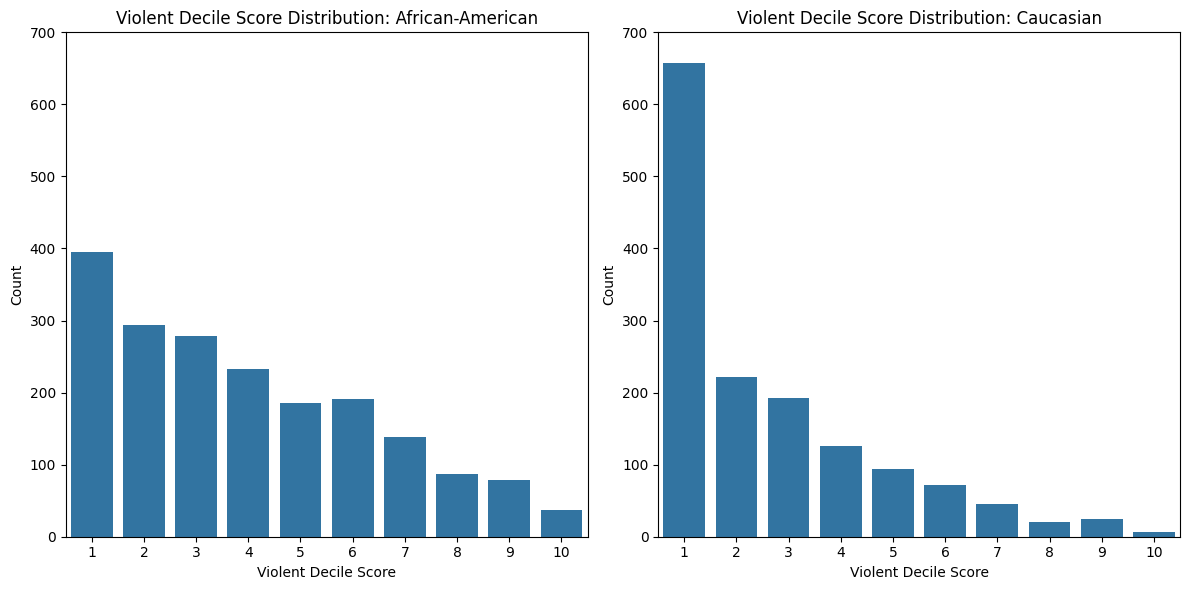

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, race_label in enumerate(['African-American', 'Caucasian']):
    subset = violent[violent.race == race_label]
    sns.countplot(x='v_decile_score', data=subset, order=sorted(violent.v_decile_score.unique()), ax=axes[i])
    axes[i].set_title(f"Violent Decile Score Distribution: {race_label}")
    axes[i].set_xlabel("Violent Decile Score")
    axes[i].set_ylabel("Count")
    axes[i].set_ylim(0, 700)

plt.tight_layout()
plt.show()


In [ ]:
df['crime_factor'] = pd.Categorical(df['c_charge_degree'])
df['age_factor'] = pd.Categorical(df['age_cat'])
# Reorder categories to ensure correct order and set them as ordered
df['age_factor'] = df['age_factor'].cat.reorder_categories(df['age_factor'].cat.categories, ordered=True)
df['age_factor'] = df['age_factor'].cat.set_categories(df['age_factor'].cat.categories, ordered=True)

df['race_factor'] = pd.Categorical(df['race'])
race_labels = ["African-American", "Asian", "Caucasian", "Hispanic", "Native American", "Other"]
df['race_factor'] = df['race_factor'].cat.rename_categories(race_labels)
# Set reference level
df['race_factor'] = df['race_factor'].cat.reorder_categories(['Caucasian'] + [r for r in race_labels if r != 'Caucasian'], ordered=True)


df['gender_factor'] = pd.Categorical(df['sex']).rename_categories({'Male': "Male", 'Female': 'Female'})
df['gender_factor'] = df['gender_factor'].cat.reorder_categories(['Male', 'Female'], ordered=True)

df['score_factor'] = pd.Categorical(df['score_text'] != "Low").rename_categories({True: "HighScore", False: "LowScore"})
# Fit the logistic regression model using statsmodels
model = smf.glm(formula='score_factor ~ gender_factor + age_factor + race_factor + priors_count + crime_factor + two_year_recid',
                data=df, family=sm.families.Binomial()).fit()

# Print the model summary
print(model.summary())


                                   Generalized Linear Model Regression Results                                   
Dep. Variable:     ['score_factor[LowScore]', 'score_factor[HighScore]']   No. Observations:                 6172
Model:                                                               GLM   Df Residuals:                     6160
Model Family:                                                   Binomial   Df Model:                           11
Link Function:                                                     Logit   Scale:                          1.0000
Method:                                                             IRLS   Log-Likelihood:                -3084.2
Date:                                                   Fri, 02 May 2025   Deviance:                       6168.4
Time:                                                           05:17:53   Pearson chi2:                 6.07e+03
No. Iterations:                                                        6   Pseudo R-squ.

In [ ]:
control = math.exp(-2.24274) / (1 + math.exp(-2.24274))
result = math.exp(0.65893) / (1 - control + (control * math.exp(0.65893)))
result

1.7739209589164604

In [ ]:
control = math.exp(-2.24274) / (1 + math.exp(-2.24274))
result = math.exp(3.14591) / (1 - control + (control * math.exp(3.14591)))
result

7.414239863565466

In [ ]:
data = pd.read_csv("./cox-parsed.csv")

# Filter and process the data
data = data[(data['score_text'] != "N/A") & (data['end'] > data['start'])]

# Create race_factor
race_labels = ["African-American", "Asian", "Caucasian", "Hispanic", "Native American", "Other"]
data['race_factor'] = pd.Categorical(data['race'], categories=race_labels)
# Set 'Caucasian' as the reference level
data['race_factor'] = data['race_factor'].cat.reorder_categories(['Caucasian'] + [x for x in race_labels if x != 'Caucasian'])

# Create score_factor, ensuring no null values and setting "Medium" as the reference
data['score_factor'] = pd.Categorical(data['score_text'])
data['score_factor'] = data['score_factor'].cat.reorder_categories(['Medium'] + [x for x in data['score_factor'].cat.categories if x != 'Medium'])

#Remove rows with null score_factor
data = data.dropna(subset=['score_factor'])


grp = data.drop_duplicates(subset=['id'])
print(len(grp))


10314


In [ ]:
grp["score_factor"].value_counts()

,count
score_factor,
Low,5751
Medium,2611
High,1952


In [ ]:
grp["race_factor"].value_counts()

,count
race_factor,
African-American,5147
Caucasian,3569
Hispanic,944
Other,571
Asian,51
Native American,32


In [ ]:
data['score_factor'] = pd.Categorical(data['score_text'])
data['score_factor'] = data['score_factor'].cat.reorder_categories(['Medium'] + [x for x in data['score_factor'].cat.categories if x != 'Medium'])
data = data.dropna(subset=['score_factor'])
# Convert 'score_factor' to numerical representation using one-hot encoding
score_factor_dummies = pd.get_dummies(data['score_factor'], prefix='score_factor', drop_first=True)
# Concatenate the dummy variables with the original dataframe
data = pd.concat([data, score_factor_dummies], axis=1)
# Select the relevant columns for the Cox model, including the dummy variables
f = data[['start','end','event'] + list(score_factor_dummies.columns)]
# Fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(f, 'end', event_col='event', entry_col='start')

# Print the model summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 13344 total observations, 9875 right-censored observations>
             duration col = 'end'
                event col = 'event'
                entry col = 'start'
      baseline estimation = breslow
   number of observations = 13344
number of events observed = 3469
   partial log-likelihood = -30305.85
         time fit was run = 2025-05-02 05:17:53 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
score_factor_High  0.45      1.57      0.04            0.37            0.54                1.45                1.71
score_factor_Low  -0.80      0.45      0.04           -0.88           -0.72                0.42                0.49

                   cmp to      z      p  -log2(p)
covariate                                        
score_factor_High    0.00  10.48 <0.005     82.92
score_factor_Low     0.00 -19.53 <0.005    279.75
---
Concordance = 0.60
Partial AIC = 60615.71
log-likelihood ratio test = 942.82 on 2 df
-log2(p) of ll-ratio test = 680.10

In [ ]:
!pip install --upgrade truth-tables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
import csv
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable

# 1. Read and validate all Person records
people = []
with open("./cox-parsed.csv", newline='') as f:
    reader = PeekyReader(csv.DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

# 2. Build the “population”:
#    include everyone with a valid score
#    AND (either a recidivist discharged ≤ 730 days OR lifetime > 730 days)
population = [
    person for person in people
    if person.score_valid
    and (
        (person.recidivist and person.lifetime <= 730)
        or person.lifetime > 730
    )
]

# 3. Extract the recidivists subset:
#    recidivists whose discharge was within 730 days
recidivists = [
    person for person in population
    if person.recidivist and person.lifetime <= 730
]

# 4. Everyone else in “population” (i.e., survivors)
recid_set = set(recidivists)
survivors = [
    person for person in population
    if person not in recid_set
]

# 5. (Optional) Inspect your counts
print(f"Total valid people:   {len(people)}")
print(f"Filtered population:  {len(population)}")
print(f"Recidivists (≤730d):  {len(recidivists)}")
print(f"Survivors (>730d):     {len(survivors)}")

Total valid people:   7225
Filtered population:  7214
Recidivists (≤730d):  3251
Survivors (>730d):     3963


In [ ]:
print("All defendants")
table(list(recidivists), list(survivors))

All defendants
           	Low	High
Survived   	2681	1282	0.55
Recidivated	1216	2035	0.45
Total: 7214.00
False positive rate: 32.35
False negative rate: 37.40
Specificity: 0.68
Sensitivity: 0.63
Prevalence: 0.45
PPV: 0.61
NPV: 0.69
LR+: 1.94
LR-: 0.55


In [ ]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, population)),
                                                statistics.stdev(map(lambda i: i.lifetime, population))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, population))))

Average followup time 622.87 (sd 392.19)
Median followup time 766


In [ ]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recidivists)), list(filter(is_afam, survivors)))

Black defendants
           	Low	High
Survived   	990	805	0.49
Recidivated	532	1369	0.51
Total: 3696.00
False positive rate: 44.85
False negative rate: 27.99
Specificity: 0.55
Sensitivity: 0.72
Prevalence: 0.51
PPV: 0.63
NPV: 0.65
LR+: 1.61
LR-: 0.51


In [ ]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recidivists)), list(filter(is_white, survivors)))

White defendants
           	Low	High
Survived   	1139	349	0.61
Recidivated	461	505	0.39
Total: 2454.00
False positive rate: 23.45
False negative rate: 47.72
Specificity: 0.77
Sensitivity: 0.52
Prevalence: 0.39
PPV: 0.59
NPV: 0.71
LR+: 2.23
LR-: 0.62


In [ ]:
44.85 / 23.45

1.9125799573560769

In [ ]:
47.72 / 27.99

1.7048946052161487

In [ ]:
hightable(list(filter(is_white, recidivists)), list(filter(is_white, survivors)))

           	Low	High
Survived   	1407	81	0.61
Recidivated	771	195	0.39
Total: 2454.00
False positive rate: 5.44
False negative rate: 79.81
Specificity: 0.95
Sensitivity: 0.20
Prevalence: 0.39
PPV: 0.71
NPV: 0.65
LR+: 3.71
LR-: 0.84


In [ ]:
hightable(list(filter(is_afam, recidivists)), list(filter(is_afam, survivors)))

           	Low	High
Survived   	1511	284	0.49
Recidivated	1160	741	0.51
Total: 3696.00
False positive rate: 15.82
False negative rate: 61.02
Specificity: 0.84
Sensitivity: 0.39
Prevalence: 0.51
PPV: 0.72
NPV: 0.57
LR+: 2.46
LR-: 0.72


In [ ]:
import csv
from truth_tables import PeekyReader, Person

# 1. Read and validate all Person records from the violent CSV
vpeople = []
with open("./cox-violent-parsed.csv", newline="") as f:
    reader = PeekyReader(csv.DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

# 2. Build the “violent population”:
#    include everyone with a valid violent score
#    AND (either a violent recidivist discharged ≤ 730 days OR lifetime > 730 days)
vpop = [
    person for person in vpeople
    if person.vscore_valid
    and (
        (person.violent_recidivist and person.lifetime <= 730)
        or person.lifetime > 730
    )
]

# 3. Extract the violent recidivists subset:
#    those violent recidivists whose discharge was within 730 days
vrecid = [
    person for person in vpop
    if person.violent_recidivist and person.lifetime <= 730
]

# 4. Everyone else in “violent population” (i.e., violent survivors)
vrecid_set = set(vrecid)
vsurv = [
    person for person in vpop
    if person not in vrecid_set
]

# 5. (Optional) Inspect your counts
print(f"Total valid violent people:      {len(vpeople)}")
print(f"Filtered violent population:     {len(vpop)}")
print(f"Violent recidivists (≤730d):      {len(vrecid)}")
print(f"Violent survivors (>730d):        {len(vsurv)}")


Total valid violent people:      7201
Filtered violent population:     3435
Violent recidivists (≤730d):      807
Violent survivors (>730d):        2628


In [ ]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

All defendants
           	Low	High
Survived   	2040	588	0.77
Recidivated	313	494	0.23
Total: 3435.00
False positive rate: 22.37
False negative rate: 38.79
Specificity: 0.78
Sensitivity: 0.61
Prevalence: 0.23
PPV: 0.46
NPV: 0.87
LR+: 2.74
LR-: 0.50


In [ ]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

Black defendants
           	Low	High
Survived   	813	373	0.70
Recidivated	148	356	0.30
Total: 1690.00
False positive rate: 31.45
False negative rate: 29.37
Specificity: 0.69
Sensitivity: 0.71
Prevalence: 0.30
PPV: 0.49
NPV: 0.85
LR+: 2.25
LR-: 0.43


In [ ]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

White defendants
           	Low	High
Survived   	837	135	0.82
Recidivated	122	90	0.18
Total: 1184.00
False positive rate: 13.89
False negative rate: 57.55
Specificity: 0.86
Sensitivity: 0.42
Prevalence: 0.18
PPV: 0.40
NPV: 0.87
LR+: 3.06
LR-: 0.67


In [ ]:
38.14 / 18.46

2.066088840736728

In [ ]:
62.62 / 38.37


1.63200416992442

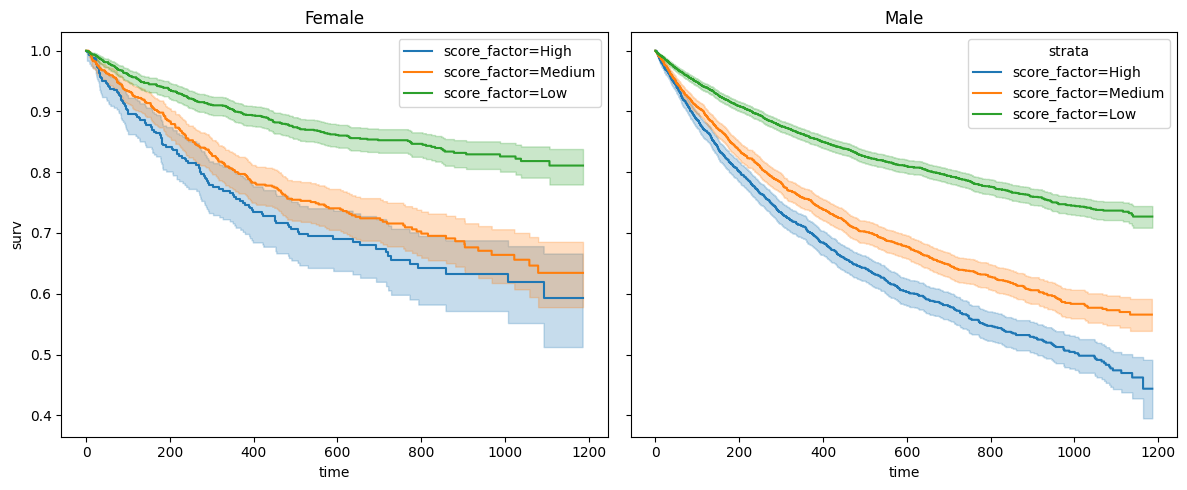

Survival summaries at t = 730 days:

--- Female ---
  High   → S(730) = 0.582 (Confidence interval not available)
  Medium → S(730) = 0.680 [0.639, 0.718]
  Low    → S(730) = 0.842 [0.820, 0.861]

--- Male ---
  High   → S(730) = 0.454 [0.426, 0.482]
  Medium → S(730) = 0.589 [0.565, 0.611]
  Low    → S(730) = 0.770 [0.757, 0.782]



In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it has a column named 'end'
# representing the time-to-event (duration)
# Replace 'end' with the actual column name if it's different

# ── 1. Prepare the figure ─────────────────────────────────────────────────────
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

# ── 2. Fit & plot by strata for each sex ───────────────────────────────────────
kmf = KaplanMeierFitter()
strata = ["High", "Medium", "Low"]
for ax, sex in zip(axes, ["Female", "Male"]):
    subset = data[data["sex"] == sex]
    for level in strata:
        mask = subset["score_factor"] == level
        # Use 'end' column as durations instead of 'time'
        kmf.fit(
            durations=subset.loc[mask, "end"],  # Changed to 'end'
            event_observed=subset.loc[mask, "event"],
            label=f"score_factor={level}"
        )
        kmf.plot(ax=ax)
    ax.set_title(sex)
    ax.set_xlabel("time")
    if sex == "Female":
        ax.set_ylabel("surv")  # match your R y-axis label

# put the legend on the rightmost plot
axes[1].legend(title="strata")
plt.tight_layout()
plt.show()


# ── 3. Summaries at t = 730 days ──────────────────────────────────────────────
time_point = 730
print(f"Survival summaries at t = {time_point} days:\n")
for sex in ["Female", "Male"]:
    subset = data[data["sex"] == sex]
    print(f"--- {sex} ---")
    for level in strata:
        mask = subset["score_factor"] == level
        # Use 'end' column as durations instead of 'time'
        kmf.fit(
            durations=subset.loc[mask, "end"] - subset.loc[mask, "start"],  # Changed to 'end'
            event_observed=subset.loc[mask, "event"],
        )
        surv_prob = kmf.predict(time_point)
        # Check if time_point is in the index before accessing it
        if time_point in kmf.confidence_interval_survival_function_.index:
            ci_low, ci_high = kmf.confidence_interval_survival_function_.loc[time_point]
            print(
                f"  {level:6s} → S({time_point}) = {surv_prob:.3f} "
                f"[{ci_low:.3f}, {ci_high:.3f}]"
            )
        else:
            print(f"  {level:6s} → S({time_point}) = {surv_prob:.3f} (Confidence interval not available)")
    print()


XGBoost Classifier Evaluation Metrics
              Score
Precision  0.650295
Recall     0.599638
F1-Score   0.623940
Accuracy   0.676923

Random Forest Classifier Evaluation Metrics
              Score
Precision  0.603943
Recall     0.610507
F1-Score   0.607207
Accuracy   0.646964

Naive Bayes Classifier Evaluation Metrics
              Score
Precision  0.602273
Recall     0.576087
F1-Score   0.588889
Accuracy   0.640486

AdaBoost Classifier Evaluation Metrics
              Score
Precision  0.641366
Recall     0.612319
F1-Score   0.626506
Accuracy   0.673684

Decision Tree Classifier Evaluation Metrics
              Score
Precision  0.578652
Recall     0.559783
F1-Score   0.569061
Accuracy   0.621053


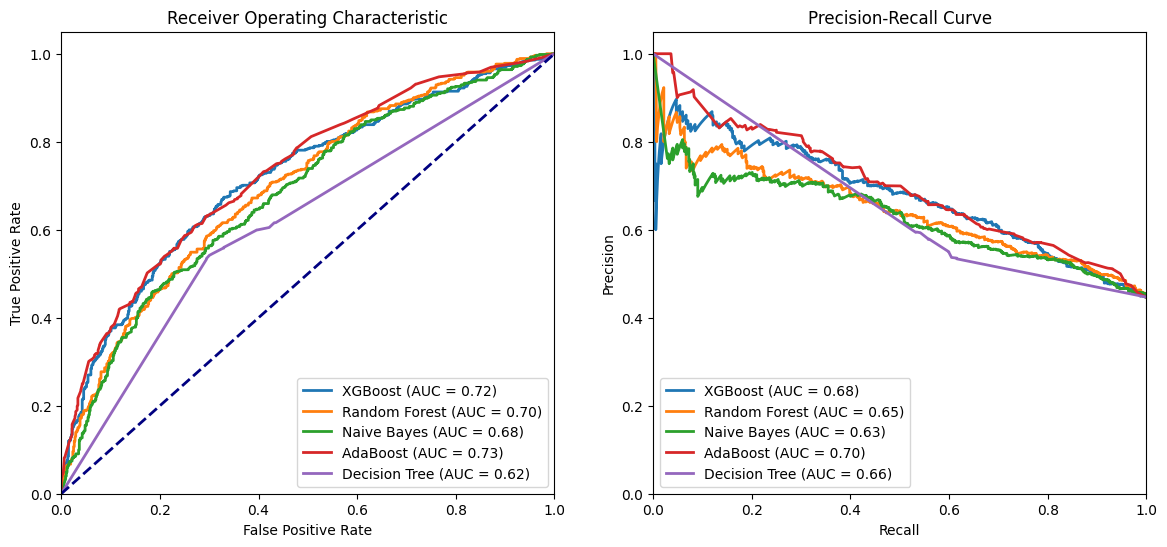

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score, classification_report, f1_score, roc_curve, auc, precision_recall_curve
import xgboost as xgb
from imblearn.combine import SMOTETomek
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
data = pd.read_csv("compas-scores-two-years.csv")


data = data[(data.days_b_screening_arrest <= 30) &
            (data.days_b_screening_arrest >= -30) &
            (data.is_recid != -1) &
            (data.c_charge_degree != 'O') &
            (data.score_text != 'N/A')]

data['length_of_stay'] = (pd.to_datetime(data['c_jail_out']) - pd.to_datetime(data['c_jail_in'])).dt.days


features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'length_of_stay']
target = 'two_year_recid'

data = data[features + [target]]


categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']
data = pd.get_dummies(data, columns=categorical_cols)


X = data.drop(target, axis=1)
y = data[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)


def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    metrics_dict = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': accuracy}
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='index', columns=['Score'])
    print(f"\n===============================================\n{model_name} Evaluation Metrics")
    print(metrics_df)


    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall_curve, precision_curve)

    return fpr, tpr, roc_auc, recall_curve, precision_curve, pr_auc


def plot_curves(models):
    plt.figure(figsize=(14, 6))


    plt.subplot(1, 2, 1)
    for model_name, (fpr, tpr, roc_auc, recall, precision, pr_auc) in models.items():
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')


    plt.subplot(1, 2, 2)
    for model_name, (fpr, tpr, roc_auc, recall, precision, pr_auc) in models.items():
        plt.plot(recall, precision, lw=2, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')

    plt.show()

models = {}


params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}
xg_model = xgb.XGBClassifier(**params)
xg_model.fit(X_train_balanced, y_train_balanced)
models["XGBoost"] = evaluate_model(xg_model, X_test, y_test, "XGBoost Classifier")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)
models["Random Forest"] = evaluate_model(rf_model, X_test, y_test, "Random Forest Classifier")

# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_balanced, y_train_balanced)
models["Naive Bayes"] = evaluate_model(nb_model, X_test, y_test, "Naive Bayes Classifier")

# AdaBoost
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train_balanced, y_train_balanced)
models["AdaBoost"] = evaluate_model(ada_model, X_test, y_test, "AdaBoost Classifier")

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_balanced, y_train_balanced)
models["Decision Tree"] = evaluate_model(dt_model, X_test, y_test, "Decision Tree Classifier")


plot_curves(models)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import pandas as pd
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.optimize import differential_evolution


url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

df = df[(df.days_b_screening_arrest <= 30) &
        (df.days_b_screening_arrest >= -30) &
        (df.is_recid != -1) &
        (df.c_charge_degree != 'O') &
        (df.score_text != 'N/A')]

df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days

features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'length_of_stay']
target = 'two_year_recid'

df = df[features + [target]]

categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']
df = pd.get_dummies(df, columns=categorical_cols)

df[target] = df[target].astype(int)
df = df.fillna(df.median())

X = df.drop([target], axis=1)
y = df[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance the dataset using SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

# Sensitive feature to consider
sensitive_features = ['sex_Male']

def compute_statistical_parity(xgboost_y_pred, X_test):
    privileged = xgboost_y_pred[(X_test['sex_Male'] == 1)]
    unprivileged = xgboost_y_pred[(X_test['sex_Male'] == 0)]

    privileged_proportion = np.mean(privileged)
    unprivileged_proportion = np.mean(unprivileged)

    statistical_parity_difference = privileged_proportion - unprivileged_proportion

    return statistical_parity_difference

def compute_counterfactual_fairness(xgboost_model, X_test):
    original_predictions = xgboost_model.predict(X_test)

    counterfactual_X_test = X_test.copy()
    counterfactual_X_test['sex_Male'] = 1 - counterfactual_X_test['sex_Male']

    original_probabilities = xgboost_model.predict_proba(X_test)[:, 1]
    counterfactual_probabilities = xgboost_model.predict_proba(counterfactual_X_test)[:, 1]

    counterfactual_fairness_original = np.abs(original_probabilities - counterfactual_probabilities)

    return counterfactual_fairness_original

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42,
}

def objective_function(x):
    learning_rate, max_depth, n_estimators = x

    params['learning_rate'] = learning_rate
    params['max_depth'] = int(max_depth)
    params['n_estimators'] = int(n_estimators)

    model = XGBClassifier(**params)
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    individual_fairness = compute_statistical_parity(y_pred, X_test)

    weight_accuracy = 0.7
    weight_fairness = 0.3

    fairness_mean = np.mean(individual_fairness)

    objective_value = -(weight_accuracy * accuracy) + (weight_fairness * fairness_mean)

    return objective_value

bounds = [(0.001, 0.5), (1, 10), (10, 200)]


result = differential_evolution(objective_function, bounds, maxiter=10)


best_params = result.x
best_cost = result.fun

print("Best Parameters:", best_params)
print("Best Cost:", best_cost)

best_learning_rate, best_max_depth, best_n_estimators = best_params

params['learning_rate'] = best_learning_rate
params['max_depth'] = int(best_max_depth)
params['n_estimators'] = int(best_n_estimators)

model = XGBClassifier(**params)
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
individual_fairness = compute_statistical_parity(y_pred, X_test)
counterfactual_fairness_original = compute_counterfactual_fairness(model, X_test)

print("Best Accuracy: {:.2f}%".format(accuracy * 100))
print("Best Statistical Parity (Group Fairness):", individual_fairness)
print("Best Counterfactual Fairness (Individual Fairness):", np.mean(counterfactual_fairness_original))

Best Parameters: [1.01218801e-02 2.82561589e+00 9.19775952e+01]
Best Cost: -0.43964712753761986
Best Accuracy: 65.91%
Best Statistical Parity (Group Fairness): 0.07243130227001199
Best Counterfactual Fairness (Individual Fairness): 0.0


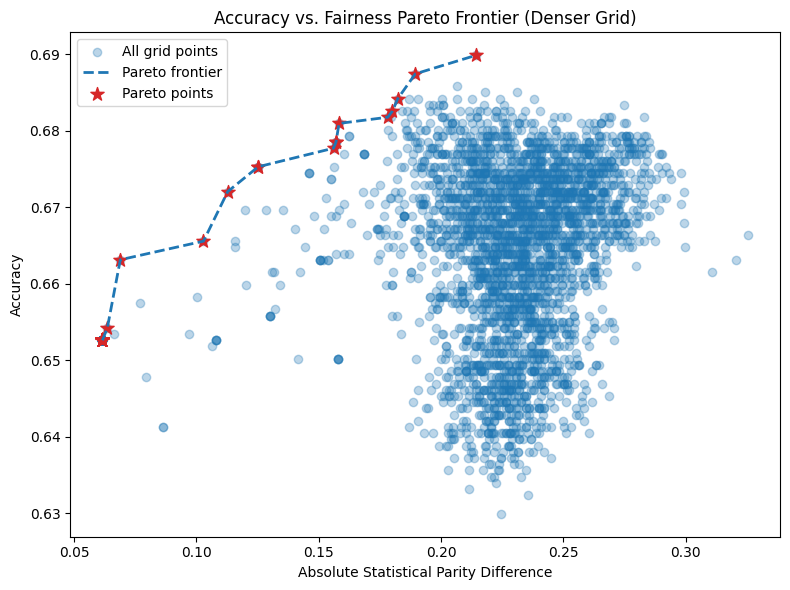

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek

# 1. Load and preprocess data
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

df = df[(df.days_b_screening_arrest <= 30) &
        (df.days_b_screening_arrest >= -30) &
        (df.is_recid != -1) &
        (df.c_charge_degree != 'O') &
        (df.score_text != 'N/A')]

df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) -
                        pd.to_datetime(df['c_jail_in'])).dt.days

features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text',
            'sex', 'priors_count', 'length_of_stay']
target = 'two_year_recid'
df = df[features + [target]]

categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']
df = pd.get_dummies(df, columns=categorical_cols)
df[target] = df[target].astype(int)
df = df.fillna(df.median())

X = df.drop([target], axis=1)
y = df[target]

# 2. Split and balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(
    X_train, y_train
)

# 3. Fairness metric
sensitive_feature = 'sex_Male'
def compute_statistical_parity(y_pred, X):
    priv = y_pred[X[sensitive_feature] == 1]
    unpriv = y_pred[X[sensitive_feature] == 0]
    return np.mean(priv) - np.mean(unpriv)

# 4. Pareto‐frontier helper
def pareto_frontier(points, maximize=(True, False)):
    N = points.shape[0]
    is_pareto = np.ones(N, dtype=bool)
    for i in range(N):
        if not is_pareto[i]:
            continue
        for j in range(N):
            if i == j:
                continue
            better_or_equal = []
            strictly_better = False
            for k in (0,1):
                if maximize[k]:
                    better_or_equal.append(points[j,k] >= points[i,k])
                    if points[j,k] > points[i,k]:
                        strictly_better = True
                else:
                    better_or_equal.append(points[j,k] <= points[i,k])
                    if points[j,k] < points[i,k]:
                        strictly_better = True
            if all(better_or_equal) and strictly_better:
                is_pareto[i] = False
                break
    return np.where(is_pareto)[0]

# 5. Build a denser hyperparameter grid
lrs        = np.linspace(0.001, 0.5, 20)           # 20 learning-rate values
max_depths = list(range(1, 16))                    # depths 1 through 15
n_ests     = np.linspace(10, 200, 10, dtype=int)   # 10 n_estimators values
grid = [(lr, md, ne) for lr in lrs for md in max_depths for ne in n_ests]

# 6. Evaluate every grid point
results = []
for lr, md, ne in grid:
    model = XGBClassifier(
        learning_rate=lr,
        max_depth=md,
        n_estimators=ne,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        seed=42
    )
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    sp  = compute_statistical_parity(y_pred, X_test)
    results.append((acc, abs(sp)))

# 7. Extract Pareto‐optimal points
arr    = np.array(results)  # shape (~3000,2)
idx_pf = pareto_frontier(arr, maximize=(True, False))
pf     = arr[idx_pf]

# 8. Plot
acc_all  = arr[:,0]
fair_all = arr[:,1]
acc_pf   = pf[:,0]
fair_pf  = pf[:,1]

# sort frontier by fairness for the line
order     = np.argsort(fair_pf)
fair_pf_s = fair_pf[order]
acc_pf_s  = acc_pf[order]

plt.figure(figsize=(8,6))
plt.scatter(fair_all, acc_all, alpha=0.3, label='All grid points')
plt.plot(  fair_pf_s, acc_pf_s, linestyle='--', linewidth=2, label='Pareto frontier')
plt.scatter(fair_pf_s, acc_pf_s, s=100, marker='*', color='C3', label='Pareto points')
plt.xlabel('Absolute Statistical Parity Difference')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Fairness Pareto Frontier (Denser Grid)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from scipy.optimize import minimize


url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv("compas-scores-two-years.csv")


df = df[(df.days_b_screening_arrest <= 30) &
        (df.days_b_screening_arrest >= -30) &
        (df.is_recid != -1) &
        (df.c_charge_degree != 'O') &
        (df.score_text != 'N/A')]

df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days

features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'length_of_stay']
target = 'two_year_recid'

df = df[features + [target]]

categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']
df = pd.get_dummies(df, columns=categorical_cols)

df[target] = df[target].astype(int)
df = df.fillna(df.median())

X = df.drop([target], axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

sensitive_feature = 'sex_Male'

# Define compute_counterfactual_fairness outside of fitness_function
def compute_counterfactual_fairness(xgboost_model, X_test):
    original_probabilities = xgboost_model.predict_proba(X_test)[:, 1]

    counterfactual_X_test = X_test.copy()
    counterfactual_X_test[sensitive_feature] = 1 - counterfactual_X_test[sensitive_feature]

    counterfactual_probabilities = xgboost_model.predict_proba(counterfactual_X_test)[:, 1]

    counterfactual_fairness = np.abs(original_probabilities - counterfactual_probabilities)
    return np.mean(counterfactual_fairness)

def fitness_function(params):
    learning_rate, max_depth, n_estimators = params

    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        seed=42
    )


    model.fit(X_train_balanced, y_train_balanced)


    y_pred = model.predict(X_test)


    accuracy = accuracy_score(y_test, y_pred)


    privileged = y_pred[(X_test[sensitive_feature] == 1)]
    unprivileged = y_pred[(X_test[sensitive_feature] == 0)]

    privileged_proportion = np.mean(privileged)
    unprivileged_proportion = np.mean(unprivileged)

    statistical_parity = privileged_proportion - unprivileged_proportion


    counterfactual_fairness = compute_counterfactual_fairness(model, X_test) # Call the function now defined globally


    fitness = 0.6 * accuracy - 0.2 * np.abs(statistical_parity) - 0.2 * counterfactual_fairness

    return -fitness


def bounds_transform(params):
    learning_rate = np.clip(params[0], 0.001, 0.5)
    max_depth = int(np.clip(params[1], 1, 10))
    n_estimators = int(np.clip(params[2], 10, 200))
    return [learning_rate, max_depth, n_estimators]


initial_guess = [0.1, 5, 50]


result = minimize(
    lambda params: fitness_function(bounds_transform(params)),
    initial_guess,
    method='Nelder-Mead',
    options={'xatol': 1e-8, 'fatol': 1e-8, 'maxiter': 50}
)

best_solution = result.x
best_learning_rate, best_max_depth, best_n_estimators = bounds_transform(best_solution)

print(f"Best Parameters: learning_rate={best_learning_rate}, max_depth={best_max_depth}, n_estimators={best_n_estimators}")
print(f"Best Fitness: {-result.fun}")


model = XGBClassifier(
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    n_estimators=best_n_estimators,
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',
    seed=42
)

model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
privileged = y_pred[(X_test[sensitive_feature] == 1)]
unprivileged = y_pred[(X_test[sensitive_feature] == 0)]
statistical_parity = np.mean(privileged) - np.mean(unprivileged)

counterfactual_fairness = compute_counterfactual_fairness(model, X_test)

print(f"Final Accuracy: {accuracy}")
print(f"Final Statistical Parity: {statistical_parity}")
print(f"Final Counterfactual Fairness: {counterfactual_fairness}")

Best Parameters: learning_rate=0.10247638653130003, max_depth=5, n_estimators=51
Best Fitness: 0.3239639852856393
Final Accuracy: 0.6785425101214575
Final Statistical Parity: 0.24090667728660559
Final Counterfactual Fairness: 0.17490091919898987


Optimized params: 0.10247638653130003 5 51


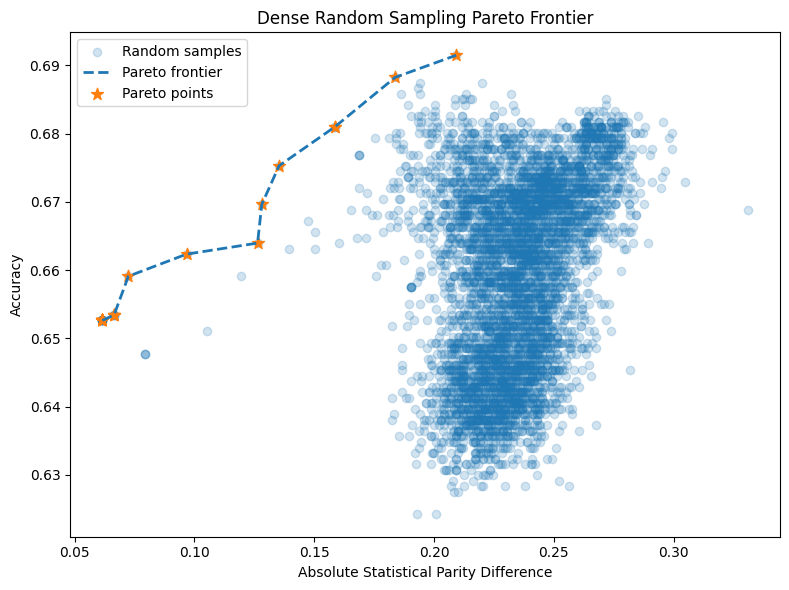

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from scipy.optimize import minimize

# 1. Load and preprocess data
df = pd.read_csv("compas-scores-two-years.csv")  # or your local copy

df = df[(df.days_b_screening_arrest <= 30) &
        (df.days_b_screening_arrest >= -30) &
        (df.is_recid != -1) &
        (df.c_charge_degree != 'O') &
        (df.score_text != 'N/A')]

df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) -
                        pd.to_datetime(df['c_jail_in'])).dt.days

features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text',
            'sex', 'priors_count', 'length_of_stay']
target = 'two_year_recid'
df = df[features + [target]]

categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']
df = pd.get_dummies(df, columns=categorical_cols)
df[target] = df[target].astype(int)
df = df.fillna(df.median())

X = df.drop([target], axis=1)
y = df[target]

# 2. Split and balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(
    X_train, y_train
)

sensitive_feature = 'sex_Male'

# 3. Fairness & utility functions
def compute_statistical_parity(y_pred, X):
    priv   = y_pred[X[sensitive_feature] == 1]
    unpriv = y_pred[X[sensitive_feature] == 0]
    return np.mean(priv) - np.mean(unpriv)

def compute_counterfactual_fairness(model, X):
    orig_prob = model.predict_proba(X)[:, 1]
    cf_X = X.copy()
    cf_X[sensitive_feature] = 1 - cf_X[sensitive_feature]
    cf_prob = model.predict_proba(cf_X)[:, 1]
    return np.mean(np.abs(orig_prob - cf_prob))

def fitness_function(params):
    lr, md, ne = params
    model = XGBClassifier(
        learning_rate=lr,
        max_depth=int(md),
        n_estimators=int(ne),
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        seed=42
    )
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    sp  = compute_statistical_parity(y_pred, X_test)
    cf  = compute_counterfactual_fairness(model, X_test)
    return -(0.6 * acc - 0.2 * abs(sp) - 0.2 * cf)

def bounds_transform(p):
    lr  = np.clip(p[0], 0.001, 0.5)
    md  = int(np.clip(p[1], 1, 15))       # expanded to 15
    ne  = int(np.clip(p[2], 10, 500))     # expanded to 500
    return [lr, md, ne]

# 4. (Optional) Nelder-Mead to get a good starting point
initial = [0.1, 5, 50]
res = minimize(lambda p: fitness_function(bounds_transform(p)),
               initial, method='Nelder-Mead',
               options={'xatol':1e-8,'fatol':1e-8,'maxiter':50})
best_lr, best_md, best_ne = bounds_transform(res.x)
print("Optimized params:", best_lr, best_md, best_ne)

# 5. Pareto‐frontier helper
def pareto_frontier(points, maximize=(True, False)):
    N = points.shape[0]
    is_pf = np.ones(N, dtype=bool)
    for i in range(N):
        if not is_pf[i]:
            continue
        for j in range(N):
            if i == j:
                continue
            better, strictly = [], False
            for k in (0,1):
                if maximize[k]:
                    better.append(points[j,k] >= points[i,k])
                    strictly |= points[j,k] > points[i,k]
                else:
                    better.append(points[j,k] <= points[i,k])
                    strictly |= points[j,k] < points[i,k]
            if all(better) and strictly:
                is_pf[i] = False
                break
    return np.where(is_pf)[0]

# 6. Denser random sampling for more frontier points
samples = []
n_samples = 5000  # increased sample size
for _ in range(n_samples):
    lr = random.uniform(0.001, 0.5)
    md = random.randint(1, 15)     # expanded depth range
    ne = random.randint(10, 500)   # expanded estimator range
    model = XGBClassifier(
        learning_rate=lr,
        max_depth=md,
        n_estimators=ne,
        objective='binary:logistic',
        eval_metric='auc',
        tree_method='hist',
        seed=42
    )
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    sp  = compute_statistical_parity(y_pred, X_test)
    samples.append((acc, abs(sp)))

arr = np.array(samples)
idx_pf = pareto_frontier(arr, maximize=(True, False))
pf    = arr[idx_pf]

# 7. Plot full scatter plus a richer Pareto frontier
acc_all, fair_all = arr[:,0], arr[:,1]
acc_pf,  fair_pf  = pf[:,0],  pf[:,1]
order = np.argsort(fair_pf)
fair_pf_s, acc_pf_s = fair_pf[order], acc_pf[order]

plt.figure(figsize=(8,6))
plt.scatter(fair_all, acc_all, alpha=0.2, label='Random samples')
plt.plot(   fair_pf_s, acc_pf_s, '--', linewidth=2, label='Pareto frontier')
plt.scatter(fair_pf_s, acc_pf_s, s=80, marker='*', label='Pareto points')
plt.xlabel('Absolute Statistical Parity Difference')
plt.ylabel('Accuracy')
plt.title('Dense Random Sampling Pareto Frontier')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek

# Load the COMPAS dataset
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

# Data preprocessing
df = df[(df.days_b_screening_arrest <= 30) &
        (df.days_b_screening_arrest >= -30) &
        (df.is_recid != -1) &
        (df.c_charge_degree != 'O') &
        (df.score_text != 'N/A')]

df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])).dt.days

# Select features and target
features = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'length_of_stay']
target = 'two_year_recid'

df = df[features + [target]]

# One-hot encode categorical columns
categorical_cols = ['c_charge_degree', 'race', 'age_cat', 'score_text', 'sex']
df = pd.get_dummies(df, columns=categorical_cols)

# Encode target variable
df[target] = df[target].astype(int)

# Define features and target
X = df.drop([target], axis=1)
y = df[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance the dataset using SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)

# Counterfactual Test: Flipping the protected attribute 'race'
counterfactual_X_test = X_test.copy()
# Assuming 'race_African-American' is the protected attribute to flip
if 'race_African-American' in counterfactual_X_test.columns:
    counterfactual_X_test['race_African-American'] = 1 - counterfactual_X_test['race_African-American']

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'max_depth': 8,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 42
}

xgb_model = XGBClassifier(**params)
xgb_model.fit(X_train_balanced, y_train_balanced)

y_prob = xgb_model.predict_proba(X_test)[:, 1]

alpha = 0.65
y_prob_sorted = np.sort(y_prob)
reject_threshold = y_prob_sorted[int(alpha * len(y_prob))]

accepted_mask = (y_prob >= reject_threshold)
rejected_mask = (y_prob < reject_threshold)

accuracy_accepted = accuracy_score(y_test[accepted_mask], xgb_model.predict(X_test[accepted_mask]))
accuracy_rejected = accuracy_score(y_test[rejected_mask], xgb_model.predict(X_test[rejected_mask]))

# Calculate fairness (Statistical Parity) for accepted and rejected instances
group_fairness_accepted = (y_test[accepted_mask] == 1).mean() - (xgb_model.predict(X_test[accepted_mask]) == 1).mean()
group_fairness_rejected = (y_test[rejected_mask] == 1).mean() - (xgb_model.predict(X_test[rejected_mask]) == 1).mean()

print('Accuracy on Accepted Instances: {:.4f}'.format(accuracy_accepted))
print('Accuracy on Rejected Instances: {:.4f}'.format(accuracy_rejected))
print('Group Fairness on Accepted Instances (Statistical Parity): {:.4f}'.format(group_fairness_accepted))
print('Group Fairness on Rejected Instances (Statistical Parity): {:.4f}'.format(group_fairness_rejected))

# Counterfactual fairness
y_prob_counterfactual = xgb_model.predict_proba(counterfactual_X_test)[:, 1]
counterfactual_fairness_original = np.abs(y_prob - y_prob_counterfactual)

alpha = 0.50
counterfactual_fairness_sorted = np.sort(counterfactual_fairness_original)
reject_threshold = counterfactual_fairness_sorted[int(alpha * len(counterfactual_fairness_original))]

accepted_mask = (counterfactual_fairness_original >= reject_threshold)
rejected_mask = (counterfactual_fairness_original < reject_threshold)

counterfactual_fairness_accepted = counterfactual_fairness_original[accepted_mask]
counterfactual_fairness_rejected = counterfactual_fairness_original[rejected_mask]

accuracy_accepted = accuracy_score(y_test[accepted_mask], xgb_model.predict(X_test[accepted_mask]))
accuracy_rejected = accuracy_score(y_test[rejected_mask], xgb_model.predict(X_test[rejected_mask]))

print('Individual Fairness on Accepted Instances (Counterfactual Fairness): {:.4f}'.format(counterfactual_fairness_accepted.mean()))
print('Individual Fairness on Rejected Instances (Counterfactual Fairness): {:.4f}'.format(counterfactual_fairness_rejected.mean()))

Accuracy on Accepted Instances: 0.6767
Accuracy on Rejected Instances: 0.6771
Group Fairness on Accepted Instances (Statistical Parity): -0.3233
Group Fairness on Rejected Instances (Statistical Parity): 0.2282
Individual Fairness on Accepted Instances (Counterfactual Fairness): 0.2279
Individual Fairness on Rejected Instances (Counterfactual Fairness): 0.0285


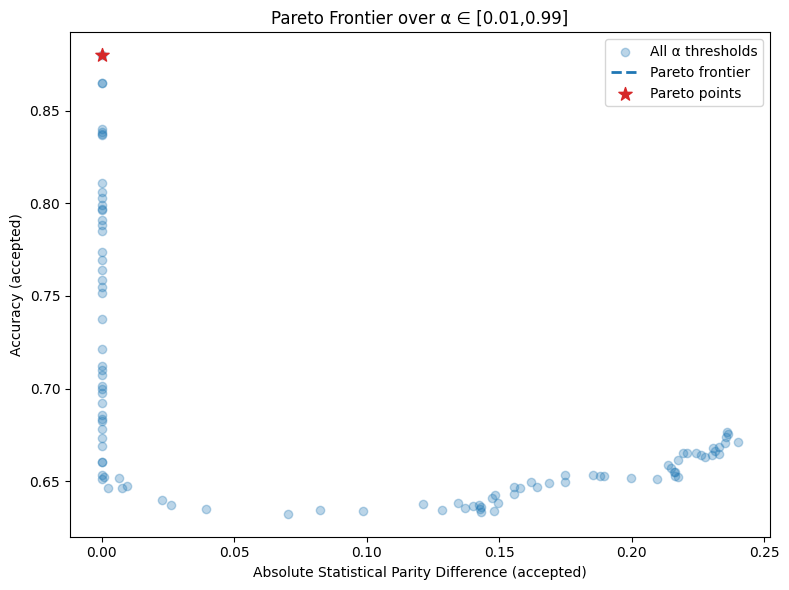

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek

# 1) Load & preprocess
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)
df = df[(df.days_b_screening_arrest <= 30) &
        (df.days_b_screening_arrest >= -30)  &
        (df.is_recid != -1)               &
        (df.c_charge_degree != 'O')      &
        (df.score_text != 'N/A')]
df['length_of_stay'] = (pd.to_datetime(df['c_jail_out']) -
                        pd.to_datetime(df['c_jail_in'])).dt.days

features = ['age','c_charge_degree','race','age_cat','score_text',
            'sex','priors_count','length_of_stay']
target = 'two_year_recid'
df = df[features + [target]]
df = pd.get_dummies(df, columns=['c_charge_degree','race','age_cat','score_text','sex'])
df[target] = df[target].astype(int)

X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
sm = SMOTETomek(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# 2) Train your fixed XGB model
params = {
    'objective':'binary:logistic','eval_metric':'auc',
    'tree_method':'hist','max_depth':8,
    'learning_rate':0.1,'n_estimators':100,'seed':42
}
model = XGBClassifier(**params)
model.fit(X_train_bal, y_train_bal)

y_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

# 3) Protected‐group mask
prot_col = 'race_African-American'
prot = (X_test[prot_col] == 1).values

# 4) Helper to compute (accuracy, |stat_parity|) at threshold α
def metrics_at_alpha(alpha):
    # compute the threshold
    thresh = np.sort(y_prob)[int(alpha * len(y_prob))]
    mask = (y_prob >= thresh)
    if mask.sum() == 0:
        return None
    # accuracy on accepted
    acc = accuracy_score(y_test[mask], y_pred[mask])
    # statistical parity on accepted:
    #   P(pred=1 | accepted, protected) - P(pred=1 | accepted, unprotected)
    preds_acc = y_pred[mask]
    prot_acc = prot[mask]
    if prot_acc.sum()>0:
        p1 = preds_acc[prot_acc].mean()
    else:
        p1 = 0.0
    if (~prot_acc).sum()>0:
        p0 = preds_acc[~prot_acc].mean()
    else:
        p0 = 0.0
    sp = p1 - p0
    return acc, abs(sp)

# 5) Sweep α in [0.01,0.99]
results = []
alphas = np.linspace(0.01, 0.99, 100)
for α in alphas:
    m = metrics_at_alpha(α)
    if m is not None:
        results.append(m)

arr = np.array(results)  # shape (≈100, 2)

# 6) Pareto‐frontier extraction
def pareto_frontier(points, maximize=(True, False)):
    N = points.shape[0]
    is_pf = np.ones(N, dtype=bool)
    for i in range(N):
        if not is_pf[i]:
            continue
        for j in range(N):
            if i == j:
                continue
            be, sb = [], False
            for k in (0,1):
                if maximize[k]:
                    be.append(points[j,k] >= points[i,k])
                    if points[j,k] > points[i,k]:
                        sb = True
                else:
                    be.append(points[j,k] <= points[i,k])
                    if points[j,k] < points[i,k]:
                        sb = True
            if all(be) and sb:
                is_pf[i] = False
                break
    return np.where(is_pf)[0]

idx_pf = pareto_frontier(arr, maximize=(True, False))
pf = arr[idx_pf]

# 7) Plot
acc_all, sp_all = arr[:,0], arr[:,1]
acc_pf, sp_pf   = pf[:,0],  pf[:,1]
order = np.argsort(sp_pf)
sp_pf_s, acc_pf_s = sp_pf[order], acc_pf[order]

plt.figure(figsize=(8,6))
plt.scatter(sp_all, acc_all, alpha=0.3, label='All α thresholds')
plt.plot(   sp_pf_s, acc_pf_s, '--', linewidth=2, label='Pareto frontier')
plt.scatter(sp_pf_s, acc_pf_s, s=100, marker='*', color='C3', label='Pareto points')
plt.xlabel('Absolute Statistical Parity Difference (accepted)')
plt.ylabel('Accuracy (accepted)')
plt.title('Pareto Frontier over α ∈ [0.01,0.99]')
plt.legend()
plt.tight_layout()
plt.show()
